# Analysis of dataset from PertirbSci-Kinetics

Here you will learn how to analyze a one-shot dataset from PertirbSci-Kinetics using the CSP model with steady-state assumptions (CSPss) and comparing it to Dynamo method.

In [1]:
import dynamo as dyn
import scanpy as sc
import anndata as ad
from scipy.sparse import csr_matrix
import numpy as np
import warnings
warnings.filterwarnings('ignore')

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


## Load and preprocess the data

In [2]:
# load new RNA counts
adata_temp = sc.read_mtx('./data/GSE218566_RAW/GSM6752591_on_target_nascent_tx_count_matrix.mtx')
label = adata_temp.X.T

# load total RNA counts
adata_temp2 = sc.read_mtx('./data/GSE218566_RAW/GSM6752591_on_target_whole_tx_count_matrix.mtx')
total = adata_temp2.X.T

time = 2 * np.ones(adata_temp.n_vars)

total = csr_matrix(total)
adata = ad.AnnData(total)
adata.layers['total'] = total
adata.layers['new'] = label
adata.obs['time'] = time

# to calculate faster we downsampled 1/30 of the cells
adata = adata[np.arange(0, adata.n_obs, 30), :]

In [3]:
dyn.pp.recipe_monocle(
    adata,
    tkey="time",
    experiment_type="one-shot",
    # experiment_type="kin",
    n_top_genes=1000,
    # total_layers=False,
    keep_raw_layers=True,
    # feature_selection_layer="new",
    X_total_layers=False,
    reset_X=False,
    splicing_total_layers=False,
    total_layers=True,
    keep_filtered_cells=False,
)
dyn.tl.reduceDimension(adata)
dyn.tl.moments(adata)
del adata.layers['M_tt'], adata.layers['M_tn'], adata.layers['M_nn']

|-----> recipe_monocle_keep_filtered_genes_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_genes_key=True
|-----> apply Monocole recipe to adata...
|-----> <insert> pp to uns in AnnData Object.
|-----------> <insert> has_splicing to uns['pp'] in AnnData Object.
|-----------> <insert> has_labling to uns['pp'] in AnnData Object.
|-----------> <insert> splicing_labeling to uns['pp'] in AnnData Object.
|-----------> <insert> has_protein to uns['pp'] in AnnData Object.
|-----> ensure all cell and variable names unique.
|-----> ensure all data in different layers in csr sparse matrix format.
|-----> ensure all labeling data properly collapased
|-----> detected experiment type: one-shot
|-----------> <insert> tkey to uns['pp'] in AnnData Object.
|-----------> <insert> experiment_type to uns['pp'] in AnnData Object.
|-----> filtering cells...
|-----> <insert> pass_basic_filter to obs in AnnData Object.
|-----> 3278 cells passed basic filters.
|-----> filte

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


|-----> [dimension_reduction projection] in progress: 100.0000%
|-----> [dimension_reduction projection] finished [20.0022s]
|-----> calculating first/second moments...
|-----> [moments calculation] in progress: 100.0000%
|-----> [moments calculation] finished [51.2862s]


In [4]:
dyn.tl.louvain(adata, result_key='cluster')

|-----> accessing adj_matrix_key=connectivities built from args for clustering...
|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:pca
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> <insert> connectivities to obsp in AnnData Object.
|-----> <insert> distances to obsp in AnnData Object.
|-----> <insert> neighbors to uns in AnnData Object.
|-----> <insert> neighbors.indices to uns in AnnData Object.
|-----> <insert> neighbors.params to uns in AnnData Object.
|-----> Detecting communities on graph...
Note: to be able to use all crisp methods, you need to install some additional packages:  {'graph_tool', 'karateclub', 'leidenalg', 'wurlitzer', 'infomap'}
Note: to be able to use all overlapping methods, you need to install some additional packages:  {'ASLPAw', 'karateclub'}
Note: to be able to use all bipartite methods, you need to i

## Use CSPss and Dynamo methods to infer parameters and calculate total velocity, respectively.

In [5]:
adata_CSPss = adata.copy()
adata_Dynamo = adata.copy()
del adata

In [6]:
# for CSP with steady state
adata_CSPss.uns["pp"]["experiment_type"] = 'kin'
dyn.tl.dynamics(adata_CSPss, est_method='CSP4ML_CSPss', model='deterministic')
dyn.tl.reduceDimension(adata_CSPss, reduction_method='umap')
dyn.tl.cell_velocities(adata_CSPss, ekey='M_t', vkey='velocity_T', enforce=True)

|-----> dynamics_del_2nd_moments_key is None. Using default value from DynamoAdataConfig: dynamics_del_2nd_moments_key=False
|-----? You used tkey time (or group None), but you have calculated local smoothing (1st moment) for your data before. Please ensure you used the desired tkey or group when the smoothing was performed. Try setting re_smooth = True if not sure.
|-----? Your adata only has labeling data, but `NTR_vel` is set to be `False`. Dynamo will reset it to `True` to enable this analysis.
|-----> experiment type: kin, method: CSP4ML_CSPss, model: deterministic


Estimate gamma via linear regression of t vs. -ln(1-K): 1000it [00:01, 993.80it/s]
Infer parameters via maximum likelihood estimation based on the CSP model under the steady-state assumption: 1000it [00:00, 1114.94it/s]


(1000, 1)
|-----> retrive data for non-linear dimension reduction...
|-----? adata already have basis umap. dimension reduction umap will be skipped! 
set enforce=True to re-performing dimension reduction.
|-----> [dimension_reduction projection] in progress: 100.0000%
|-----> [dimension_reduction projection] finished [0.0016s]
|-----> 0 genes are removed because of nan velocity values.
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] finished [14.0594s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%
|-----> [projecting velocity vector to low dimensional embedding] finished [0.6799s]


AnnData object with n_obs × n_vars = 3278 × 59429
    obs: 'time', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'total_Size_Factor', 'initial_total_cell_size', 'new_Size_Factor', 'initial_new_cell_size', 'Size_Factor', 'initial_cell_size', 'ntr', 'cluster'
    var: 'nCells', 'nCounts', 'pass_basic_filter', 'log_m', 'log_cv', 'score', 'use_for_pca', 'frac', 'ntr', 'alpha', 'a', 'b', 'alpha_a', 'alpha_i', 'beta', 'p_half_life', 'gamma', 'half_life', 'cost', 'logLL', 'gamma_k', 'gamma_r2', 'gamma_r2_raw', 'prob_off', 'use_for_dynamics', 'use_for_transition'
    uns: 'pp', 'velocyto_SVR', 'PCs', 'explained_variance_ratio_', 'pca_mean', 'pca_fit', 'feature_selection', 'neighbors', 'umap_fit', 'cluster', 'dynamics', 'grid_velocity_umap'
    obsm: 'X_pca', 'X', 'X_umap', 'velocity_umap'
    layers: 'total', 'new', 'X_total', 'X_new', 'M_t', 'M_n', 'M_CSP_t', 'M_CSP_n', 'velocity_N', 'velocity_T', 'cell_wise_alpha'
    obsp: 'moments_con', 'distances', 'connectivities', 'pearson_transiti

In [7]:
# for Dynamo
dyn.tl.dynamics(adata_Dynamo, one_shot_method="sci_fate", model='deterministic')
dyn.tl.reduceDimension(adata_Dynamo, reduction_method='umap')
dyn.tl.cell_velocities(adata_Dynamo, ekey='M_t', vkey='velocity_T', enforce=True)

|-----> dynamics_del_2nd_moments_key is None. Using default value from DynamoAdataConfig: dynamics_del_2nd_moments_key=False
|-----? You used tkey time (or group None), but you have calculated local smoothing (1st moment) for your data before. Please ensure you used the desired tkey or group when the smoothing was performed. Try setting re_smooth = True if not sure.
|-----? Your adata only has labeling data, but `NTR_vel` is set to be `False`. Dynamo will reset it to `True` to enable this analysis.


estimating alpha: 100%|██████████████████| 1000/1000 [00:00<00:00, 80409.19it/s]


|-----> retrive data for non-linear dimension reduction...
|-----? adata already have basis umap. dimension reduction umap will be skipped! 
set enforce=True to re-performing dimension reduction.
|-----> [dimension_reduction projection] in progress: 100.0000%
|-----> [dimension_reduction projection] finished [0.0012s]
|-----> 0 genes are removed because of nan velocity values.
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] finished [14.9079s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%
|-----> [projecting velocity vector to low dimensional embedding] finished [0.7959s]


AnnData object with n_obs × n_vars = 3278 × 59429
    obs: 'time', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'total_Size_Factor', 'initial_total_cell_size', 'new_Size_Factor', 'initial_new_cell_size', 'Size_Factor', 'initial_cell_size', 'ntr', 'cluster'
    var: 'nCells', 'nCounts', 'pass_basic_filter', 'log_m', 'log_cv', 'score', 'use_for_pca', 'frac', 'ntr', 'alpha', 'beta', 'gamma', 'half_life', 'alpha_b', 'alpha_r2', 'gamma_b', 'gamma_r2', 'gamma_logLL', 'delta_b', 'delta_r2', 'bs', 'bf', 'uu0', 'ul0', 'su0', 'sl0', 'U0', 'S0', 'total0', 'beta_k', 'gamma_k', 'use_for_dynamics', 'use_for_transition'
    uns: 'pp', 'velocyto_SVR', 'PCs', 'explained_variance_ratio_', 'pca_mean', 'pca_fit', 'feature_selection', 'neighbors', 'umap_fit', 'cluster', 'dynamics', 'grid_velocity_umap'
    obsm: 'X_pca', 'X', 'X_umap', 'velocity_umap'
    layers: 'total', 'new', 'X_total', 'X_new', 'M_t', 'M_n', 'M_CSP_t', 'M_CSP_n', 'velocity_N', 'velocity_T'
    obsp: 'moments_con', 'distances', 'c

## Visualization

Change the settings for better visualization:

In [14]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
sc.set_figure_params(scanpy=True, fontsize=6)
figsize = (6, 4)
dpi = 600
# path = './one-shot/streamline/'
path = './rev_figures/figure2/streamline/'

### Streamline plots in UMAP space

<Figure size 600x400 with 0 Axes>

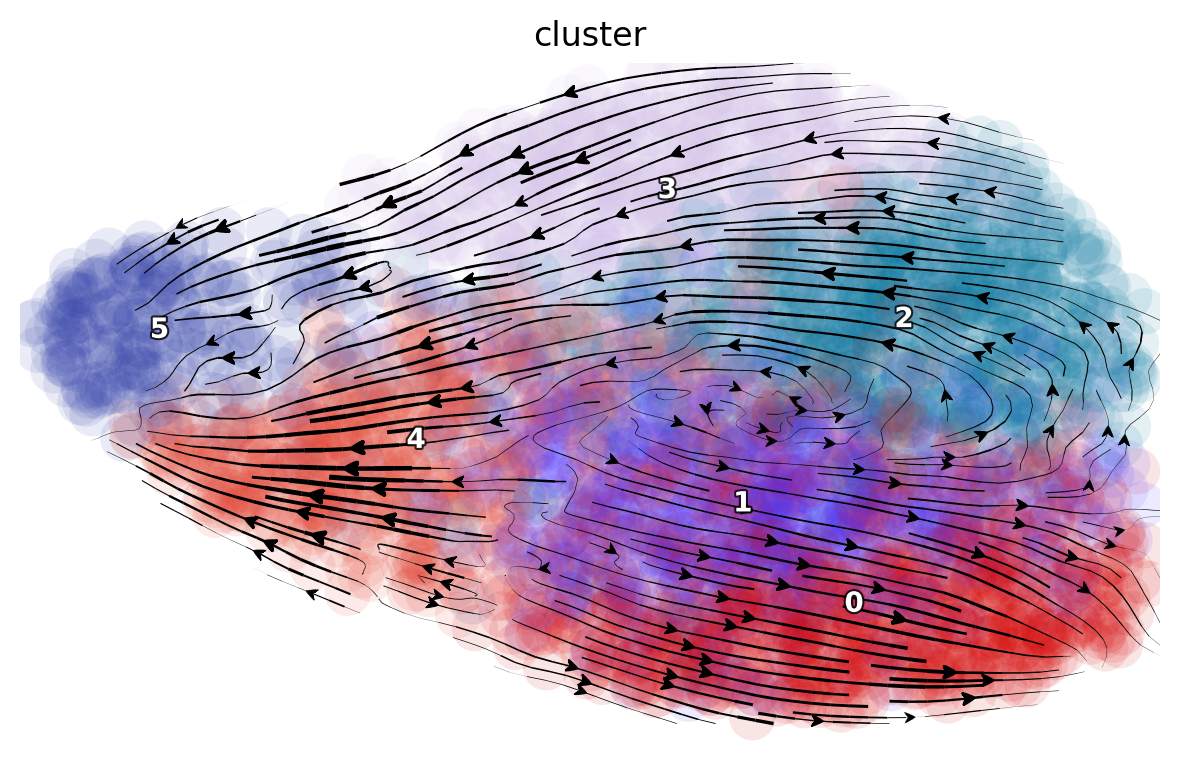

In [18]:
# CSP with steady-state
dyn.pl.streamline_plot(adata_CSPss, color='cluster', basis='umap',
                       save_show_or_return='show', save_kwargs={'prefix': 'perturbsci_umap_cspss', 'ext': 'png',
                        "bbox_inches": None, 'dpi': dpi, 'path': path}, figsize=figsize
                       )

<Figure size 600x400 with 0 Axes>

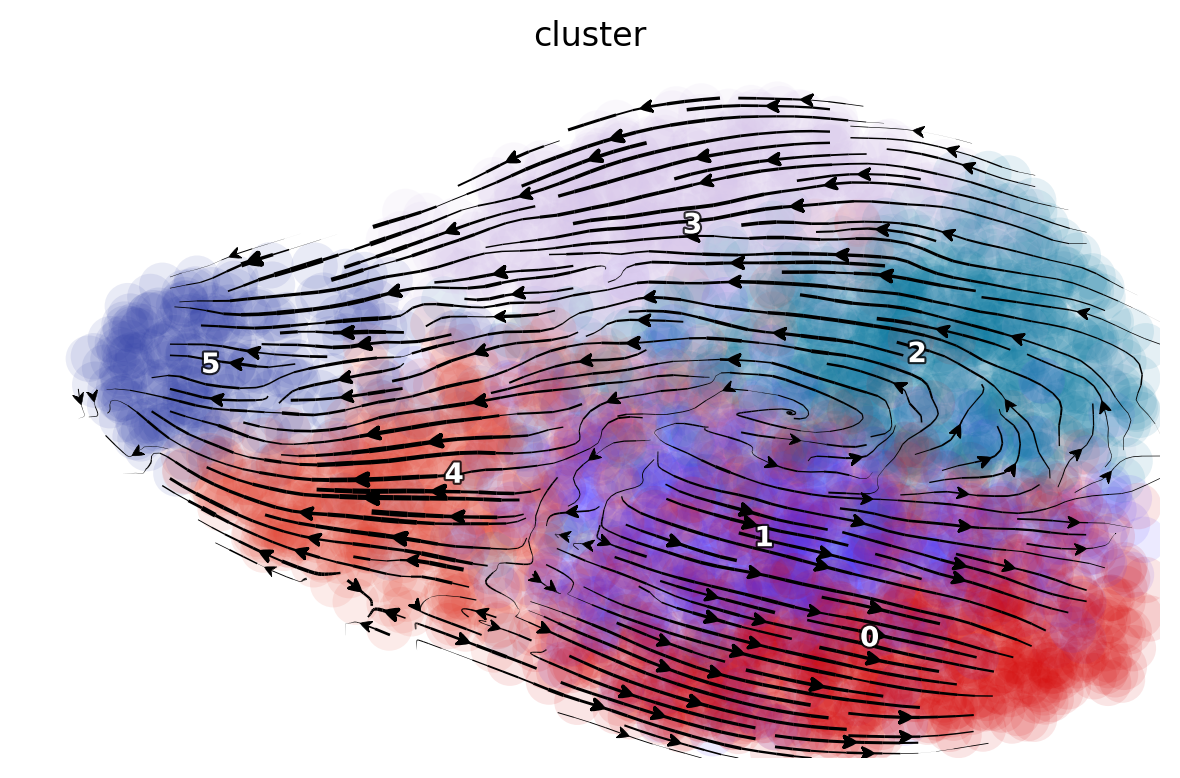

In [20]:
# Dynamo
dyn.pl.streamline_plot(adata_Dynamo, color='cluster', basis='umap',
                       save_show_or_return='show', save_kwargs={'prefix': 'perturbsci_umap_dynamo', 'ext': 'png',
                        "bbox_inches": None, 'dpi': dpi, 'path': path}, figsize=figsize
                       )

### Plot the inferred results of $\gamma_{t}$ of the two methods

In [11]:
gamma_CSPss = adata_CSPss.var['gamma'].values
gamma_Dynamo = adata_Dynamo.var['gamma'].values

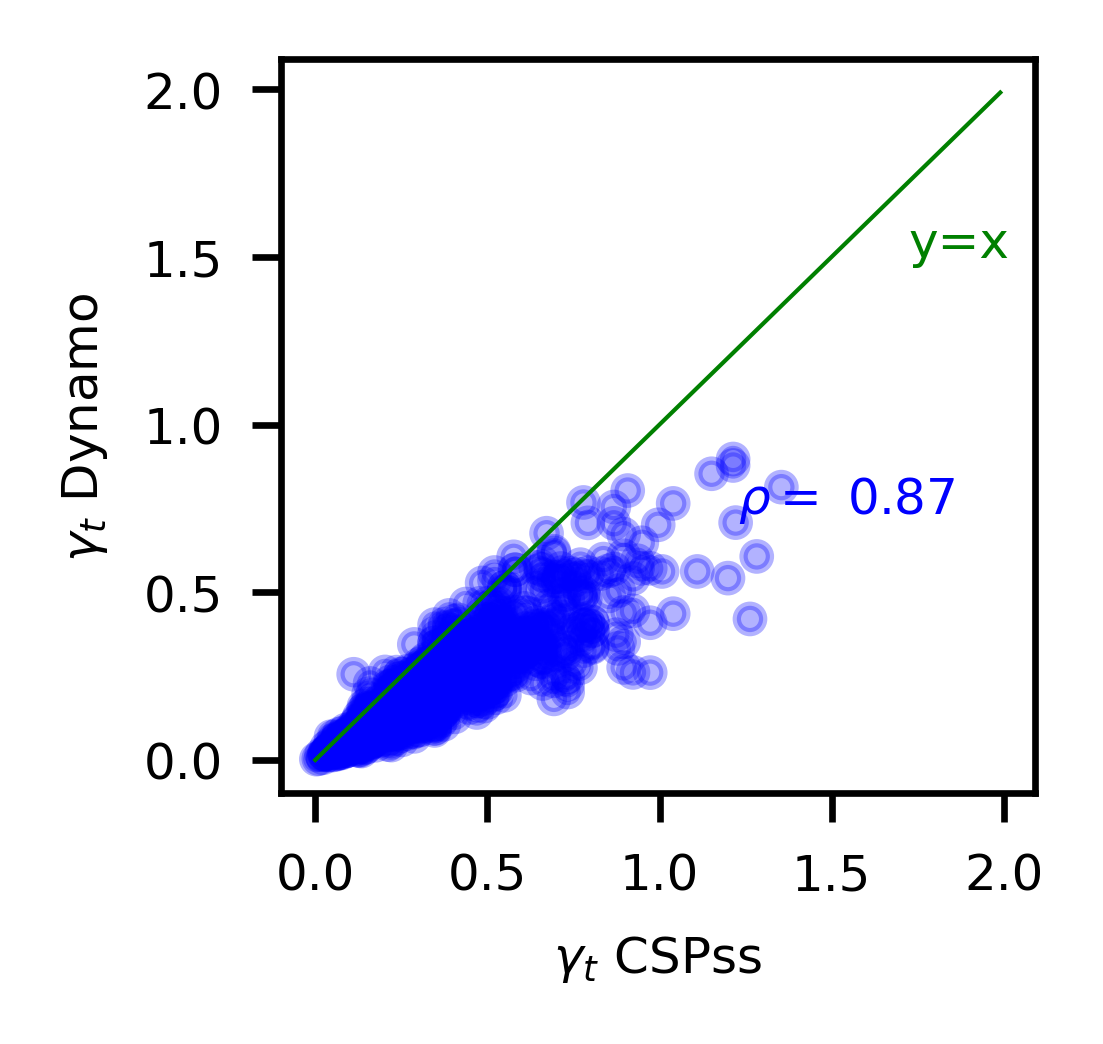

In [13]:
sc.set_figure_params(scanpy=True, fontsize=6)
scatter_size = 10
figsize = (1.61, 1.61)
alpha = 0.3
dpi = 300

gamma_CSPss = gamma_CSPss.astype('float')
gamma_Dynamo = gamma_Dynamo.astype('float')


range_min = 0
range_max = 2
x = np.arange(range_min, range_max, 0.01)
y = x

index_no_nan = np.logical_and(np.isfinite(gamma_CSPss), np.isfinite(gamma_Dynamo))
# correlation coefficient between all the genes
rho = np.corrcoef(gamma_CSPss[index_no_nan], gamma_Dynamo[index_no_nan])


fig = plt.figure(1, figsize=figsize, dpi=dpi)
ax = fig.add_subplot(111)
ax.scatter(gamma_CSPss, gamma_Dynamo, color='blue', s=scatter_size * np.ones(len(gamma_CSPss)), alpha=alpha)
ax.plot(x, y, color='g', linewidth=0.5, label='y=x')
plt.text(0.9, 0.75, 'y=x', ha='center', va='center', transform=ax.transAxes, color='g')
plt.text(0.75, 0.4, '$\\rho=$ %4.2f' % rho[0][1], 
         ha='center', va='center', transform=ax.transAxes, color='b')
plt.xlabel('$\gamma_t$ CSPss')
plt.ylabel('$\gamma_t$ Dynamo')
plt.grid(False)
plt.savefig('./rev_figures/figure2/comp/perturbsci.pdf',dpi=dpi, bbox_inches="tight")
plt.show()